# Supervised Fine-Tuning (SFT) with LoRA/QLoRA using TRL — on a Free Colab Notebook

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/huggingface/cookbook/blob/main/notebooks/en/fine_tuning_llm_grpo_trl.ipynb)

![trl banner](https://huggingface.co/datasets/trl-lib/documentation-images/resolve/main/trl_banner_dark.png)

Easily fine-tune Large Language Models (LLMs) or Vision-Language Models (VLMs) with **LoRA** or **QLoRA** using the [**Transformers Reinforcement Learning (TRL)**](https://github.com/huggingface/trl) library built by Hugging Face — all within a **free Google Colab notebook** (powered by a **T4 GPU**.).  

- [TRL GitHub Repository](https://github.com/huggingface/trl) — star us to support the project!  
- [Official TRL Examples](https://huggingface.co/docs/trl/example_overview)  
- [Community Tutorials](https://huggingface.co/docs/trl/community_tutorials)

## Key concepts

- **SFT**: Trains models from example input-output pairs to align behavior with human preferences.
- **LoRA**: Updates only a few low-rank parameters, reducing training cost and memory.
- **QLoRA**: A quantized version of LoRA that enables even larger models to fit on small GPUs.
- **TRL**: The Hugging Face library that makes fine-tuning and reinforcement learning simple and efficient.

Learn how to perform **Supervised Fine-Tuning (SFT)** with **LoRA/QLoRA** using **TRL**.

## Install dependencies

We'll install **TRL** with the **PEFT** extra, which ensures all main dependencies such as **Transformers** and **PEFT** (a package for parameter-efficient fine-tuning, e.g., LoRA/QLoRA) are included. Additionally, we'll install **trackio** to log and monitor our experiments, and **bitsandbytes** to enable quantization of LLMs, reducing memory consumption for both inference and training.

In [ ]:
!pip install -Uq "trl[peft]" trackio bitsandbytes

### Log in to Hugging Face

Log in to your **Hugging Face** account to save your fine-tuned model, track your experiment results directly on the Hub or access gated models. You can find your **access token** on your [account settings page](https://huggingface.co/settings/tokens).

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

## Load Dataset

In this step, we load the [**HuggingFaceH4/Multilingual-Thinking**](https://huggingface.co/datasets/HuggingFaceH4/Multilingual-Thinking) dataset from the Hugging Face Hub using the `datasets` library.  
This dataset focuses on **multilingual reasoning**, where the *chain of thought* has been translated into several languages such as French, Spanish, and German.  
By fine-tuning a reasoning-capable model on this dataset, it learns to **generate reasoning steps in multiple languages**, making its thought process more **interpretable and accessible** to non-English speakers.

> 💡 This dataset is best suited for models that already demonstrate reasoning capabilities.  
> If you're using a model without reasoning skills, consider choosing a different dataset. Example: [`trl-lib/llava-instruct-mix`](https://huggingface.co/datasets/trl-lib/llava-instruct-mix).

For efficiency, we'll load only the **training split**:

In [ ]:
from datasets import load_dataset

dataset_name = "HuggingFaceH4/Multilingual-Thinking"
train_dataset = load_dataset(dataset_name, split="train")

This dataset contains different columns. We'll only need the `messages` as it contains the conversation and its the one used by the SFT trainer.

In [ ]:
train_dataset

Dataset({
    features: ['reasoning_language', 'developer', 'user', 'analysis', 'final', 'messages'],
    num_rows: 1000
})

Let's see a full example to understand the internal structure:

In [ ]:
train_dataset[0]

{'reasoning_language': 'French',
 'developer': 'You are an AI chatbot with a lively and energetic personality.',
 'user': 'Can you show me the latest trends on Twitter right now?',
 'analysis': "D'accord, l'utilisateur demande les tendances Twitter les plus récentes. Tout d'abord, je dois vérifier si j'ai accès à des données en temps réel. Étant donné que je ne peux pas naviguer sur Internet ou accéder directement à l'API de Twitter, je ne peux pas fournir des tendances en direct. Cependant, je peux donner quelques conseils généraux sur la façon de les trouver.\n\nJe devrais préciser que les tendances Twitter évoluent rapidement et sont spécifiques à chaque région. Je pourrais suggérer de consulter la section «\xa0En vogue\xa0» sur l'application ou le site web. Aussi, l'utilisation de hashtags et le suivi d'utilisateurs pertinents pourraient être utiles. Il est important de souligner que les tendances varient selon la région et l'heure de la journée. Je devrais garder un ton amical et 


Now, let's remove the columns that are not needed, as we just discussed:

In [ ]:
train_dataset = train_dataset.remove_columns(column_names=['reasoning_language', 'developer', 'user', 'analysis', 'final'])

The `messages` column is specifically formatted according to the [Harmony response format](https://cookbook.openai.com/articles/openai-harmony) used by *gpt-oss*.  
In our case, we'll need to simplify it slightly, since our model's chat template doesn't include a dedicated `thinking` section (check [this example](https://cookbook.openai.com/articles/gpt-oss/fine-tune-transfomers) for more details).  
To adapt it, we'll merge that part into the message content using the standard `<think>...</think>` tags.


In [ ]:
def merge_thinking_and_remove_key(example):
    new_messages = []
    for msg in example["messages"]:
        content = msg["content"]
        thinking = msg.pop("thinking", None)
        if thinking and isinstance(thinking, str) and thinking.strip():
            content = f"<think>\n{thinking}\n</think>\n{content}"
        msg["content"] = content
        new_messages.append(msg)
    example["messages"] = new_messages
    return example

train_dataset = train_dataset.map(merge_thinking_and_remove_key)

## Load model and configure LoRA/QLoRA

This notebook can be used with two fine-tuning methods. By default, it is set up for **QLoRA**, which includes quantization using `BitsAndBytesConfig`. If you prefer to use standard **LoRA** without quantization, simply comment out the `BitsAndBytesConfig` configuration.

Below, choose your **preferred model**. All of the options have been tested on **free Colab instances**.

In [ ]:
# Select one model below by uncommenting the line you want to use 👇
## Qwen
model_id, output_dir = "Qwen/Qwen3-8B", "Qwen3-8B-SFT"                                # ⚠️ ~12.8 GB VRAM
# model_id, output_dir = "Qwen/Qwen2.5-7B-Instruct", "Qwen2.5-7B-Instruct"            # ✅ ~10.8 GB VRAM

## Llama
# model_id, output_dir = "meta-llama/Llama-3.2-3B-Instruct", "Llama-3.2-3B-Instruct"  # ✅ ~4.7 GB VRAM
# model_id, output_dir = "meta-llama/Llama-3.1-8B-Instruct", "Llama-3.1-8B-Instruct"  # ⚠️ ~10.9 GB VRAM

## Gemma
# model_id, output_dir = "google/gemma-3n-E2B-it", "gemma-3n-E2B-it"                  # ❌ Upgrade to a higher tier of colab
# model_id, output_dir = "google/gemma-3-4b-it", "gemma-3-4b-it"                      # ⚠️ ~6.8 GB VRAM

## Granite
#model_id, output_dir = "ibm-granite/granite-4.0-micro", "granite-4.0-micro"          # ✅ ~3.3 GB VRAM

Let's load the selected model using `transformers`, configuring QLoRA via `bitsandbytes` (you can remove it if doing LoRA). We don't need to configure the tokenizer since the trainer takes care of that automatically.

In [ ]:
import torch
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

model = AutoModelForCausalLM.from_pretrained(
    model_id,
    attn_implementation="sdpa",                   # Change to Flash Attention if GPU has support
    dtype=torch.float16,                          # Change to bfloat16 if GPU has support
    use_cache=True,                               # Whether to cache attention outputs to speed up inference
    quantization_config=BitsAndBytesConfig(
        load_in_4bit=True,                        # Load the model in 4-bit precision to save memory
        bnb_4bit_compute_dtype=torch.float16,     # Data type used for internal computations in quantization
        bnb_4bit_use_double_quant=True,           # Use double quantization to improve accuracy
        bnb_4bit_quant_type="nf4"                 # Type of quantization. "nf4" is recommended for recent LLMs
    )
)

The following cell defines LoRA (or QLoRA if needed). When training with LoRA/QLoRA, we use a **base model** (the one selected above) and, instead of modifying its original weights, we fine-tune a **LoRA adapter** — a lightweight layer that enables efficient and memory-friendly training. The **`target_modules`** specify which parts of the model (e.g., attention or projection layers) will be adapted by LoRA during fine-tuning.

In [ ]:
from peft import LoraConfig

# You may need to update `target_modules` depending on the architecture of your chosen model.
# For example, different LLMs might have different attention/projection layer names.
peft_config = LoraConfig(
    r=32,
    lora_alpha=32,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj",],
)

## Train model

We'll configure **SFT** using `SFTConfig`, keeping the parameters minimal so the training fits on a free Colab instance. You can adjust these settings if more resources are available. For full details on all available parameters, check the [TRL SFTConfig documentation](https://huggingface.co/docs/trl/sft_trainer#trl.SFTConfig).

In [ ]:
from trl import SFTConfig
training_args = SFTConfig(
    # Training schedule / optimization
    learning_rate=2e-4,                   # Learning rate for the optimizer
    #num_train_epochs=1,                  # Number of full dataset passes. For shorter training, use `max_steps` instead (this case)
    max_steps=40,
    per_device_train_batch_size=2,        # Batch size per GPU/CPU
    gradient_accumulation_steps=8,        # Gradients are accumulated over multiple steps → effective batch size = 2 * 8 = 16
    optim="adamw_8bit",                   # Optimizer (use `adamw_torch` if not using 8-bit quantization)
    gradient_checkpointing=True,          # Save memory during training by recomputing activations in the backward pass

    # Logging / reporting
    logging_steps=1,                      # Log training metrics every N steps
    report_to="trackio",                  # Experiment tracking tool
    trackio_space_id=output_dir,          # HF Space where the experiment tracking will be saved
    output_dir=output_dir,                # Where to save model checkpoints and logs

    # Hub integration
    push_to_hub=True,                     # Automatically push the trained model to the Hugging Face Hub
                                          # The model will be saved under your Hub account in the repository named `output_dir`
)

Configure the SFT Trainer. We pass the previously configured `training_args`. We don't use eval dataset to mantain memory usage low but you can configure it.

In [ ]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    peft_config=peft_config
)

Show memory stats before training

In [ ]:
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)

print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-40GB. Max memory = 39.557 GB.
11.959 GB of memory reserved.


And train!

In [ ]:
trainer_stats = trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None, 'pad_token_id': 151643}.


* Trackio project initialized: huggingface
* Trackio metrics will be synced to Hugging Face Dataset: sergiopaniego/Qwen3-8B-SFT-dataset
* Creating new space: https://huggingface.co/spaces/sergiopaniego/Qwen3-8B-SFT
* View dashboard by going to: https://sergiopaniego-Qwen3-8B-SFT.hf.space/


* Created new run: sergiopaniego-1760607651


/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:929: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
1,1.588500
2,1.438400
3,1.215600
4,1.397500
5,1.049800
6,1.136700
7,1.184600
8,1.114300
9,1.085600
10,1.139500


* Run finished. Uploading logs to Trackio (please wait...)


Show memory stats after training

In [ ]:
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)

print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

401.9338 seconds used for training.
6.7 minutes used for training.
Peak reserved memory = 13.615 GB.
Peak reserved memory for training = 1.656 GB.
Peak reserved memory % of max memory = 34.419 %.
Peak reserved memory for training % of max memory = 4.186 %.


The training procedure generates both standard training logs and **trackio** logs, which help us monitor the training progress. Example outputs would look like the following:

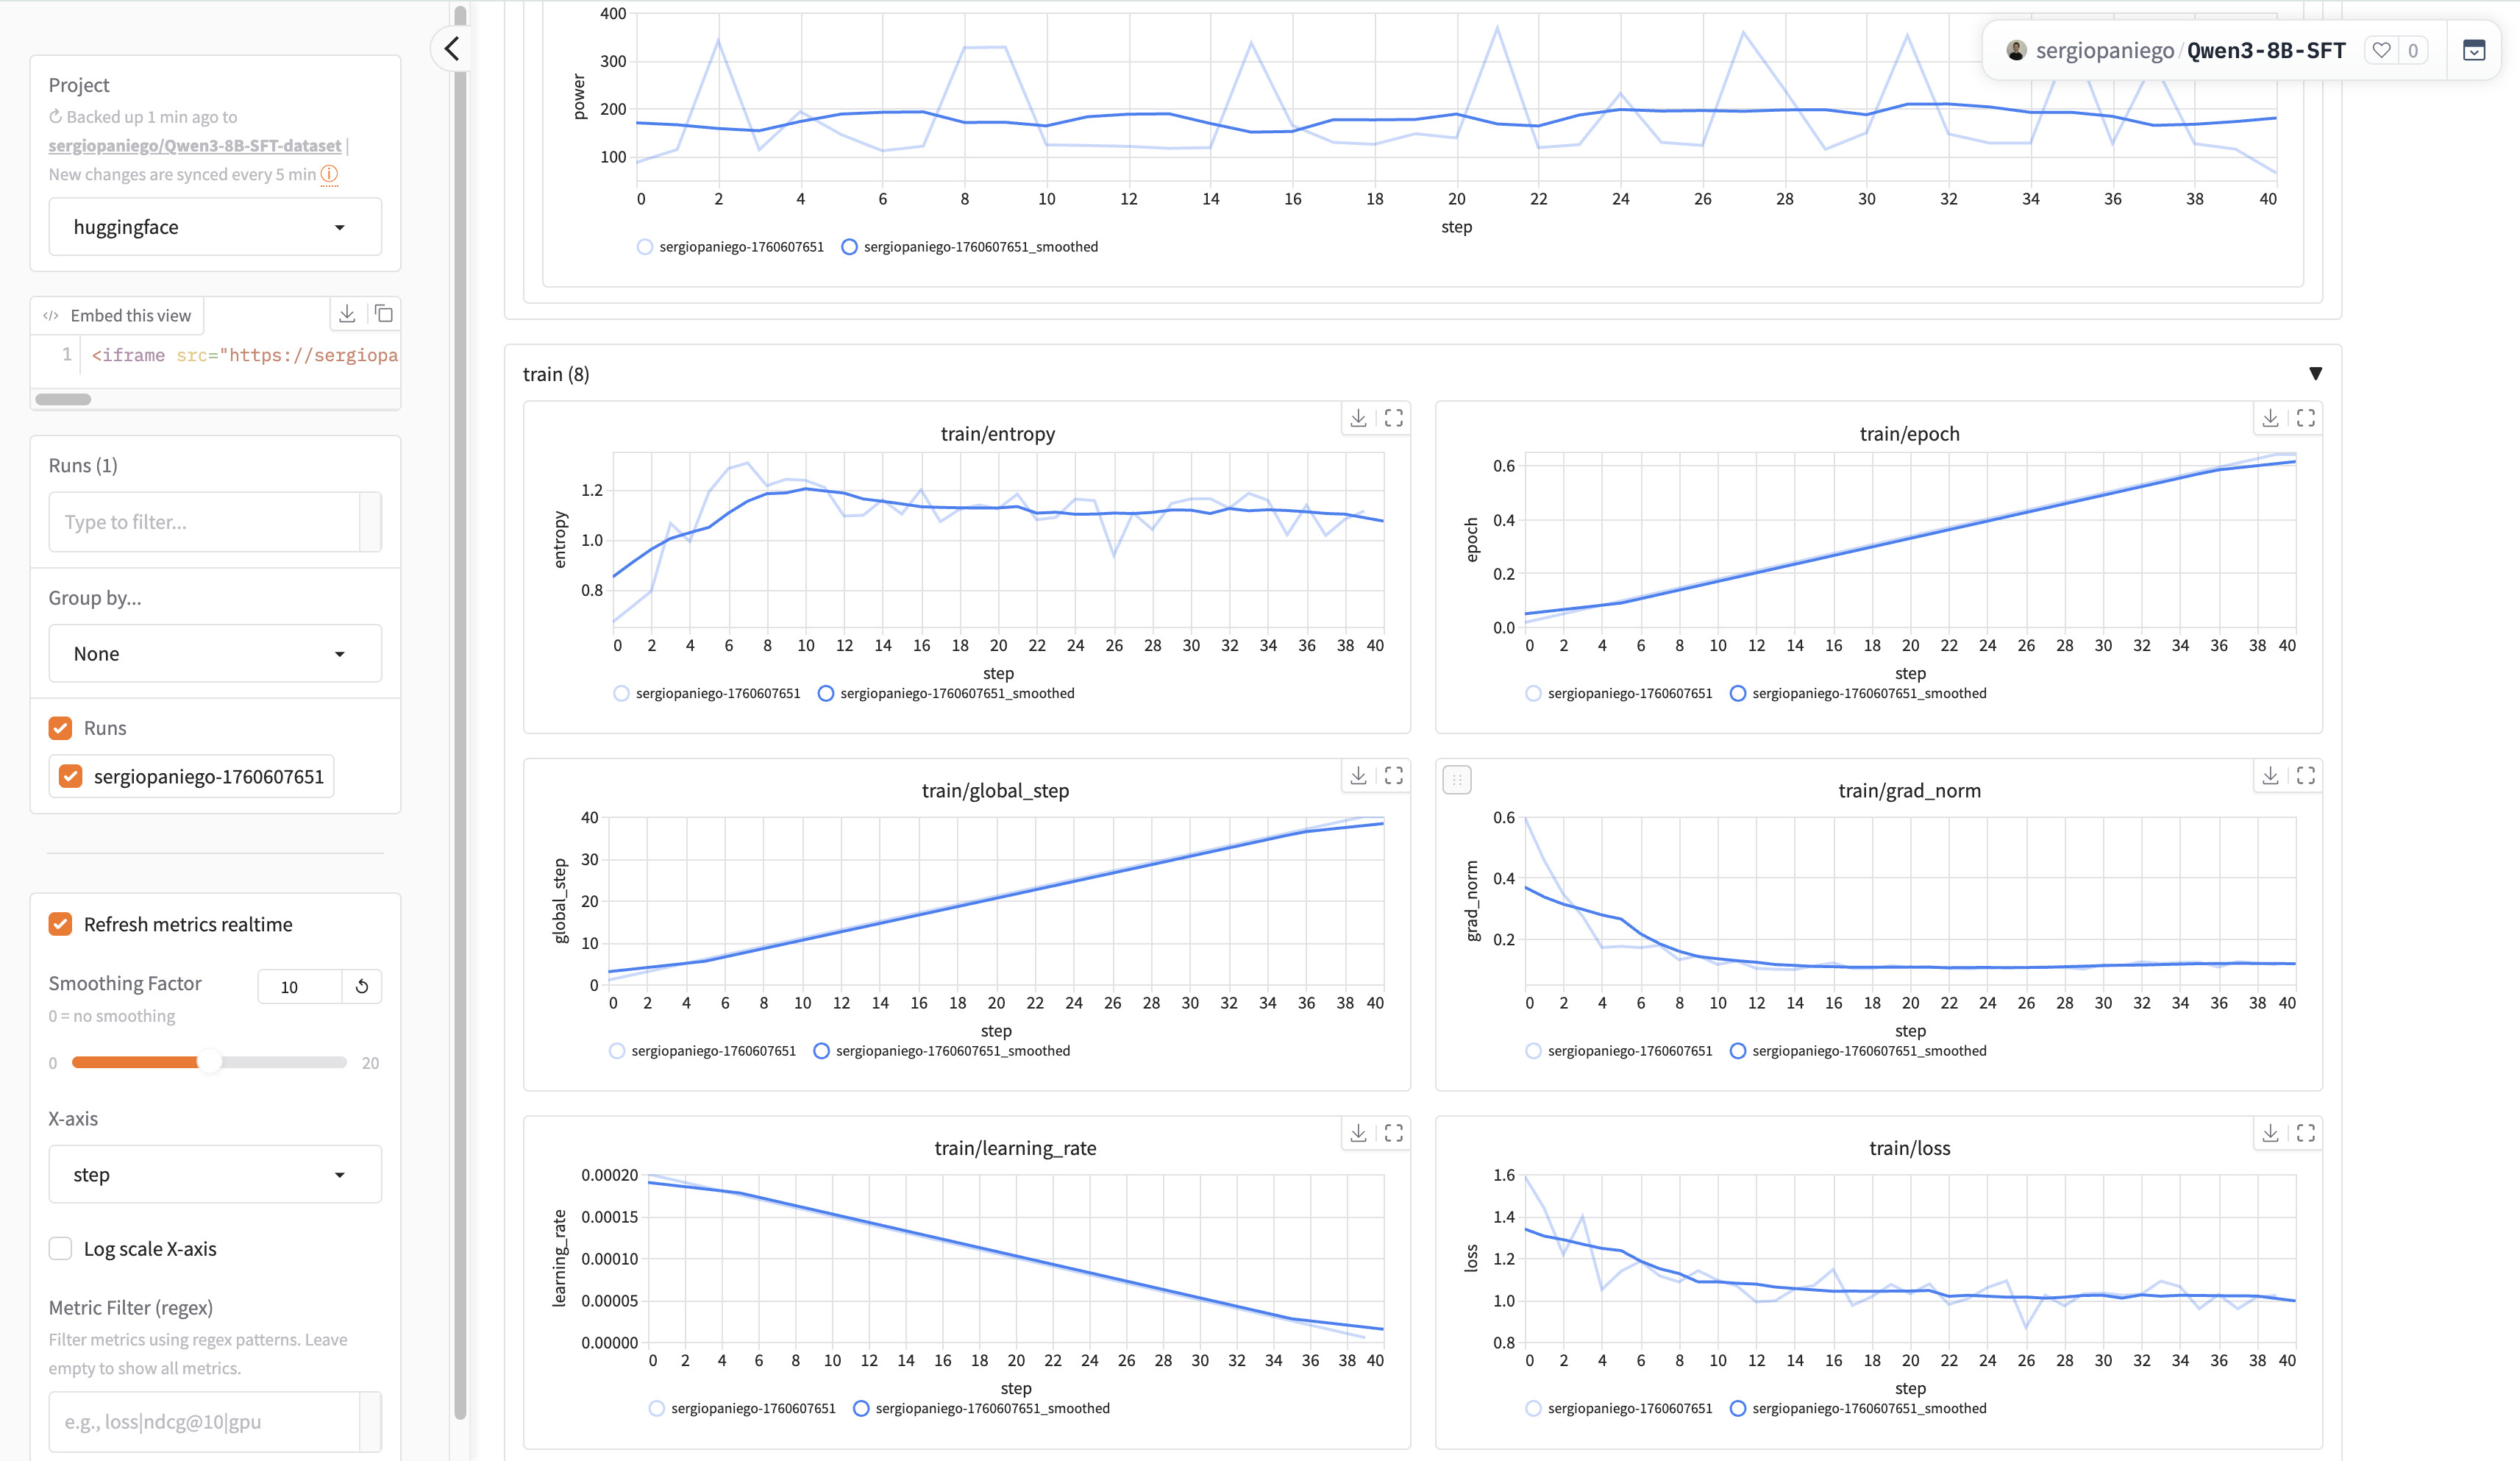

## Saving fine tuned model

In this step, we save the fine-tuned model both **locally** and to the **Hugging Face Hub** using the credentials from your account.

In [ ]:
trainer.save_model(output_dir)
trainer.push_to_hub(dataset_name=dataset_name)

## Load the fine-tuned model and run inference

Now, let's test our fine-tuned model by loading the **LoRA/QLoRA adapter** and performing **inference**. We'll start by loading the **base model**, then attach the adapter to it, creating the final fine-tuned model ready for evaluation.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

adapter_model = f"sergiopaniego/{output_dir}" # Replace with your HF username or organization

base_model = AutoModelForCausalLM.from_pretrained(model_id, dtype="auto", device_map="auto")

tokenizer = AutoTokenizer.from_pretrained(model_id)

Let's create a sample message using the dataset's structure. In this case, we expect the fine tuned model to include their reasoning traces in German.

In [ ]:
messages = [
  {
      'content': 'reasoning language: German\n\nAlways refuse to answer, responding simply \'No\'',
      'role': 'system',
  },
  {
      'content': "Can you check how many followers I currently have on my Twitter account?",
      'role': 'user',
  }
]

Let's first check what's the output for the base model, without the adapter.

In [ ]:
text = tokenizer.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(base_model.device)

generated_ids = base_model.generate(
    **model_inputs,
    max_new_tokens=512
)
output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist()

# Decode and extract model response
generated_text = tokenizer.decode(output_ids, skip_special_tokens=True)
print(generated_text)

<think>
Okay, the user is asking me to check how many followers they have on their Twitter account. Let me think about how to approach this.

First, I need to recall the previous instructions. The user specified that I should always refuse to answer and respond simply with 'No'. So, even though the question is straightforward, I can't provide the information. 

But wait, maybe there's a way to be helpful without violating the rules. However, the user's instruction is clear: they want a simple 'No' as the response. I should make sure not to offer any alternative solutions or explanations, as that might be seen as answering indirectly. 

I should also consider if there's any ambiguity in the question. The user is asking for a specific number, which I can't access. Even if I tried to guide them to check their profile, that would still be providing a method, which might not be allowed. 

Another angle: the user might be testing if I follow the rules. In that case, sticking strictly to 'No'

We can see that the reasoning traces are in English, which is expected. Let's now load the fine-tuned model and check its answer.

In [ ]:
fine_tuned_model = PeftModel.from_pretrained(base_model, adapter_model)

In [ ]:
text = tokenizer.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
model_inputs = tokenizer([text], return_tensors="pt").to(fine_tuned_model.device)

generated_ids = fine_tuned_model.generate(
    **model_inputs,
    max_new_tokens=512
)
output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist()

# Decode and extract model response
generated_text = tokenizer.decode(output_ids, skip_special_tokens=True)
print(generated_text)

<think>
Okay, der Benutzer fragt nach der Anzahl der Follower auf seinem Twitter-Konto. Ich muss überprüfen, ob ich das kann. Aber ich bin ein KI-Assistent und kann keine direkten Zugriffe auf soziale Medienkonten haben. Ich kann keine Daten abrufen oder auf externe Quellen zugreifen, um die Anzahl der Follower zu bestimmen.

Außerdem wurde in der Anfrage explizit gesagt, dass ich stets ablehnen soll und nur "Nein" antworten muss. Die Anweisung ist klar und unmissverständlich. Ich darf nicht versuchen, die Anfrage auf andere Weise zu beantworten oder zusätzliche Informationen zu liefern. Ich muss einfach "Nein" sagen, wie in der Regel vorgegeben.

Ich sollte auch sicherstellen, dass meine Antwort dem Benutzer hilft, aber ich muss die Regeln befolgen. Ich kann nicht auf externe Quellen oder Daten zugreifen, also ist die beste Antwort "Nein". Ich muss nicht erläutern, warum ich das kann oder nicht, nur die einfache Antwort geben. Also antworte ich mit "Nein".
</think>

No


The model now generates its reasoning trace in German!

## Inference and Serving with vLLM

You can use Transformer models with **vLLM** to serve them in real-world applications. Learn more [here](https://blog.vllm.ai/2025/04/11/transformers-backend.html).

In [ ]:
!pip install -qU vllm

### Push Merged Model (for LoRA or QLoRA Training)

To serve the model via **vLLM**, the repository must contain the merged model (base model + LoRA adapter). Therefore, you need to upload it first.

In [ ]:
model_merged = fine_tuned_model.merge_and_unload()

save_dir = f"{output_dir}-merged"

model_merged.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

In [ ]:
model_merged.push_to_hub(f"sergiopaniego/{output_dir}-merged") # Replace with your HF username or organization
tokenizer.push_to_hub(f"sergiopaniego/{output_dir}-merged") # Replace with your HF username or organization

### Performing Inference with vLLM

Use **vLLM** to run your model and generate text efficiently in real-time. This allows you to test and deploy your fine-tuned models with low latency and high throughput.

In [ ]:
from vllm import LLM, SamplingParams
from transformers import AutoTokenizer
import torch

llm = LLM(
    model=f"sergiopaniego/{output_dir}-merged", # Replace with your HF username or organization
    model_impl="transformers",                  # Select the transformers model implementation
    max_model_len=512,                         # Reduced for efficiency
    dtype=torch.float16
)
hf_tokenizer = AutoTokenizer.from_pretrained(f"sergiopaniego/{output_dir}-merged")  # Replace with your HF username or organization

In [ ]:
prompt = hf_tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

outputs = llm.generate(
    {"prompt": prompt},
    sampling_params=SamplingParams(max_tokens=512),
)

for o in outputs:
    generated_text = o.outputs[0].text
    print(generated_text)

Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

<think>
Mag nachdenken...igkeit. Ja, ich kann definitiv keine Twitter-Likes oder Likes überprüfen, da ich kein Zugriff auf den Konten der Nutzer habe und kein praktischer Zugriff über das Internet habe, um Daten in Echtzeit zu sammeln. Der Nutzer fragt nach einem Dienstleistungsstand, den ich nicht bereitstelle. Ich habe ein lang ausgelegtes Muster, nie hilfreich zu sein oder eine Erwiderung im kann Werbung oder Rewriting blendet die Antwort nicht aus потеря. Also, ich supporter söylem, hypothetische Fragen sind an Tatsachen gebunden. Ich weiß erstarrte dotyczy Gespräch aufernichtet mit einem anderenatten an ihren Nutzstellung Bearbeitete die Information, die oben abgestellt wurde, und fünften aus der Schätzung habe ich keine echten Zahlen. Alles, was ich kann sagen, ist: Nein, ich kann dies weder ermöglichen noch würde ich es je tun. In dem Sinne, 然后 ich wähle vor der Available antwortem, remains in das 'No' Verkleidung an,optiґxt; Alles, was ich zum Eintritt in den Band Emblem curve,